In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 1997#509
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

2023-12-16 21:31:04.191514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-16 21:31:05.670183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:31:05.672577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:31:05.674983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

Running on GPU


In [2]:
### Sverdrup 
# mainDir  = '/scratch2/pillarh/eccov4r4'
# gridDir  = mainDir + '/GRID'
# thetaDir = mainDir + '/eccov4r4_nctiles_daily/THETA'

### Lonestar6
mainDir  = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
gridDir  = mainDir
thetaDir = mainDir

In [3]:
# %%capture --no-stderr --no-stdout --no-display 

# #### https://stackoverflow.com/questions/72821108/hdf5-warnings-when-accessing-xarray-dataset
# #### Necessary to suppress stderr output that crashes the file
# from dask.distributed import Client
# c = Client(threads_per_worker=1)

# #### Write thetaSurf data year-wise to netcdf file in scracth2
# #### I did it manually one year at a time in list `years` since stderr output crashes the file

# def subset(ds):
#     dict_subset = {'k':0}
#     ds_subset = ds.isel(dict_subset); # ; at the end to suppress output
#     return ds_subset; # ; at the end to suppress output

# years = np.arange(1992,2018)

# # for year in years:
# #     ds = xr.open_mfdataset(join(thetaDir,f'{year}/*/*.nc'), preprocess=subset); # ; at the end to suppress output
# #     ds.to_netcdf(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4_{year}.nc', mode='w')

# for year in years:
#     print(year)
#     ds = xr.open_mfdataset(join(saltDir,f'{year}/*/*.nc'), preprocess=subset); # ; at the end to suppress output
#     ds.to_netcdf(f'/scratch2/shreyas/LRP_eccov4r4_data/saltSurfECCOv4r4_{year}.nc', mode='w')

In [4]:
### Sverdrup  - /scratch2/shreyas/LRP_eccov4r4_data
### Lonestar6 - /work/07665/shrey911/ls6/LRP_eccov4r4_data

ds = xr.open_dataset(f'/work/07665/shrey911/ls6/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')

In [5]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds['XC'].data
YC = ds['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

ds = ds.assign(hFacC_mask   = da_hFacC_mask,
          latMask      = da_latMask,
          maskFinal    = da_maskFinal,
          NaNmaskFinal = da_NaNmaskFinal)

wetpoints = np.nonzero(ds['maskFinal'].data)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r4_data/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


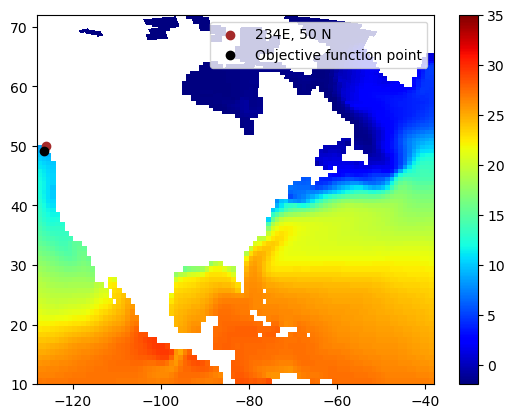

In [6]:
plt.pcolor(ds['XC'].isel(tile = 10), ds['YC'].isel(tile = 10), 
           ds['NaNmaskFinal'].isel(tile = 10)*ds['THETA'].isel(time = 0, tile = 10), 
           cmap = 'jet', vmax = 35)
plt.colorbar()
plt.scatter(-126.0, 50.0, color = 'brown', label = '234E, 50 N')
plt.scatter(ds['XC'].isel(tile = 10, j = 1, i = 43),
            ds['YC'].isel(tile = 10, j = 1, i = 43),
            color = 'black', label = 'Objective function point')
plt.legend()

Text(0.5, 1.0, 'MaskedTheta 1992_01_01')

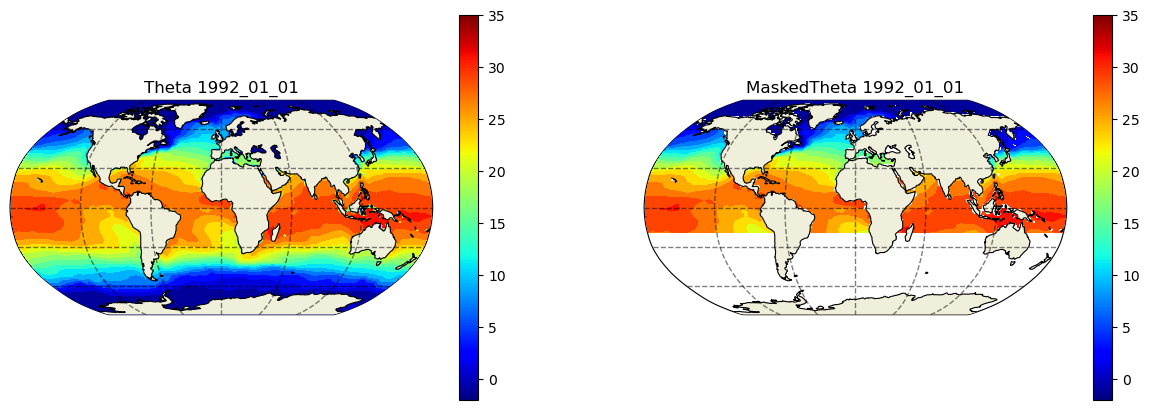

In [7]:
plt.figure(figsize=(15,5))

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              ds['THETA'].isel(time = 0),
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmax = 35,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [1,2,1]);
P[1].set_title("Theta 1992_01_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              ds['NaNmaskFinal']*ds['THETA'].isel(time = 0),
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmax = 35,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [1,2,2]);
P[1].set_title("MaskedTheta 1992_01_01")

In [8]:
# X = ds['THETA'].data[731:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
# leap_yr_offsets_jan_feb   = [0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6]
# leap_yr_offsets_after_feb = [0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6]

X = ds['THETA'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
leap_yr_offsets_jan_feb   = [0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7]
leap_yr_offsets_after_feb = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7]

seasonal_trend = np.zeros((366, X.shape[1]))

#### Calculate seasonal trend

# Jan 1 - Feb 28
for d in range(59):
    for year in range(26):
        seasonal_trend[d] += X[d+365*year+leap_yr_offsets_jan_feb[year]]
seasonal_trend[:59] = seasonal_trend[:59] / 26.0

# Feb 29 starting 1996, so year 2 in 0-indexing
n = 0
for year in range(0,26,4):
    seasonal_trend[59] += X[365*year+n+59]
    n = n+1
seasonal_trend[59] = seasonal_trend[59] / 7.0
        
# Mar 1 - Dec 31
for d in range(60,366):
    for year in range(26):
        seasonal_trend[d] += X[d-1+365*year+leap_yr_offsets_after_feb[year]]
seasonal_trend[60:] = seasonal_trend[60:] / 26.0

#### Deseason data

# Jan 1 - Feb 28
for d in range(59):
    for year in range(26):
        X[d+365*year+leap_yr_offsets_jan_feb[year]] = X[d+365*year+leap_yr_offsets_jan_feb[year]] \
                                                    - seasonal_trend[d]

# Feb 29 starting 1996, so year 2 in 0-indexing
n = 0
for year in range(0,26,4):
    X[365*year+n+59] = X[365*year+n+59] - seasonal_trend[59]
    n = n+1
        
# Mar 1 - Dec 31
for d in range(60,366):
    for year in range(26):
        X[d-1+365*year+leap_yr_offsets_after_feb[year]] = X[d-1+365*year+leap_yr_offsets_after_feb[year]] \
                                                        - seasonal_trend[d]

scipy.signal.detrend(X, axis=0, type='linear', bp=0, overwrite_data=True)
X = X - np.mean(X, axis = 0)

X_full = X.copy()
X = X[30:-30]

In [9]:
# y = ds['THETA'].isel(tile = 10, j = 1, i = 43).data[731:].copy()
# leap_yr_offsets_jan_feb   = [0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6]
# leap_yr_offsets_after_feb = [0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6]

y = ds['THETA'].isel(tile = 10, j = 1, i = 43).data.copy()
leap_yr_offsets_jan_feb   = [0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7]
leap_yr_offsets_after_feb = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7]

seasonal_trend = np.zeros((366,))

#### Calculate seasonal trend

# Jan 1 - Feb 28
for d in range(59):
    for year in range(26):
        seasonal_trend[d] += y[d+365*year+leap_yr_offsets_jan_feb[year]]
seasonal_trend[:59] = seasonal_trend[:59] / 26.0

# Feb 29 starting 1996, so year 2 in 0-indexing
n = 0
for year in range(0,26,4):
    seasonal_trend[59] += y[365*year+n+59]
    n = n+1
seasonal_trend[59] = seasonal_trend[59] / 7.0
        
# Mar 1 - Dec 31
for d in range(60,366):
    for year in range(26):
        seasonal_trend[d] += y[d-1+365*year+leap_yr_offsets_after_feb[year]]
seasonal_trend[60:] = seasonal_trend[60:] / 26.0

#### Deseason data

# Jan 1 - Feb 28
for d in range(59):
    for year in range(26):
        y[d+365*year+leap_yr_offsets_jan_feb[year]] =  y[d+365*year+leap_yr_offsets_jan_feb[year]] - seasonal_trend[d]

# Feb 29 starting 1996, so year 2 in 0-indexing
n = 0
for year in range(0,26,4):
    y[365*year+n+59] = y[365*year+n+59] - seasonal_trend[59]
    n = n+1
        
# Mar 1 - Dec 31
for d in range(60,366):
    for year in range(26):
        y[d-1+365*year+leap_yr_offsets_after_feb[year]] = y[d-1+365*year+leap_yr_offsets_after_feb[year]] - seasonal_trend[d]

scipy.signal.detrend(y, axis=0, type='linear', bp=0, overwrite_data=True)
y = y - np.mean(y, axis = 0)

# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

In [10]:
np.sum(oneHotCost[:,0]), np.sum(oneHotCost[:,1])

(4225, 5212)

In [11]:
theta_anomaly = np.zeros((X_full.shape[0],ds['THETA'].shape[1], ds['THETA'].shape[2], ds['THETA'].shape[3]), dtype = np.float64)
theta_anomaly[...] = np.nan
theta_anomaly[:,wetpoints[0],wetpoints[1],wetpoints[2]] = X_full

Text(0.5, 1.0, 'Theta anomaly 2017_06_01')

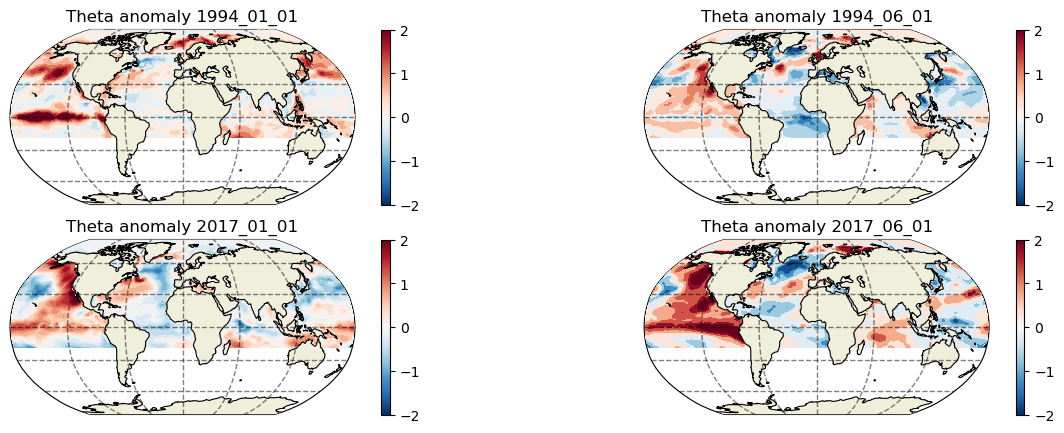

In [12]:
plt.figure(figsize=(15,5))

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[0],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,1]);
P[1].set_title("Theta anomaly 1994_01_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[180],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,2]);
P[1].set_title("Theta anomaly 1994_06_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[8400],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,3]);
P[1].set_title("Theta anomaly 2017_01_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[8581],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,4]);
P[1].set_title("Theta anomaly 2017_06_01")

## Classification - All data as training data

In [13]:
def quickSetup(X, y_oneHot, y, 
               numVars, 
               lrp_methods, 
               lagSteps,
               decay_func = None,
               **NNkwargs):
    
    result = {}

    while True:

        keras.backend.clear_session()
        sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
        NNkwargs['optimizer'] = sgd
        
        if lagSteps > 0:
            K = TrainFullyConnectedNN(X[:-lagSteps], y_oneHot[lagSteps:], **NNkwargs)
        elif lagSteps == 0:
            K = TrainFullyConnectedNN(X, y_oneHot, **NNkwargs)
        else:
            K = TrainFullyConnectedNN(X[-lagSteps:], y_oneHot[:lagSteps], **NNkwargs)
            
        best_model = K.quickTrain(decay_func)
        result['cost_predict_NN'] = best_model.predict(X)
            
        pred_NN = result['cost_predict_NN'].copy()
        pred_NN[:,0] = pred_NN[:,0] > 0.5
        pred_NN[:,1] = pred_NN[:,1] > 0.5
    
        idx_NN_pos = []
        idx_NN_neg = []
    
        if lagSteps >= 0:
            for i in range(len(oneHotCost[lagSteps:,0])):
                if oneHotCost[lagSteps+i,0] == 1 and pred_NN[i,0] == 1:
                    idx_NN_pos.append(i)
                if oneHotCost[lagSteps+i,1] == 1 and pred_NN[i,1] == 1:
                    idx_NN_neg.append(i)
        else:
            for i in range(len(oneHotCost[:lagSteps,0])):
                if oneHotCost[i,0] == 1 and pred_NN[i-lagSteps,0] == 1:
                    idx_NN_pos.append(i-lagSteps)
                if oneHotCost[i,1] == 1 and pred_NN[i-lagSteps,1] == 1:
                    idx_NN_neg.append(i-lagSteps)

        if len(idx_NN_pos) != 0 and len(idx_NN_neg) != 0:
            break

    print(len(idx_NN_pos), len(idx_NN_neg))
    
    normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
    kwargs = {'y_ref': 0.00}

    # Create model without trailing softmax
    model_wo_softmax = innvestigate.model_wo_softmax(best_model)

    rel = np.zeros((numVars, len(idx_NN_pos), 13, 90, 90))
    rel[:,:,:,:,:] = np.nan

    for numvar in range(numVars):
        rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = X[idx_NN_pos].T.copy()
    result['samples_correct_pos'] = rel

    rel = np.zeros((numVars, len(idx_NN_neg), 13, 90, 90))
    rel[:,:,:,:,:] = np.nan
        
    for numvar in range(numVars):
        rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = X[idx_NN_neg].T.copy()
    result['samples_correct_neg'] = rel
                   
    for method in lrp_methods:

        title = method['title']
        
        print(f'Analyze using {title}')
        
        Xplain = XAIR(model_wo_softmax, method, 'classic', X[idx_NN_pos], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, a.shape[0], 13, 90, 90))
        rel[:,:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a[:,numvar*perVar:(numvar+1)*perVar].T.copy()
        result[method['name']+'_pos'] = rel

        Xplain = XAIR(model_wo_softmax, method, 'classic', X[idx_NN_neg], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, a.shape[0], 13, 90, 90))
        rel[:,:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a[:,numvar*perVar:(numvar+1)*perVar].T.copy()
        result[method['name']+'_neg'] = rel
        
    return result

In [14]:
Layers = [{'size': X.shape[1], 'activation': None     , 'use_bias': None},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 'l2_w_reg': 10  , 'l2_b_reg': 10},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01},
          {'size': 2         , 'activation': 'softmax', 'use_bias': False, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01}]

Losses = [{'kind': 'categorical_crossentropy', 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 25.0
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    return lrate


methods = [dict(name='lrp.z', optParams = {}, title = 'LRP-Z')]

In [15]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    
    NNkwargs = {'losses': Losses, 'metrics': [metrics.categorical_accuracy],
                'batch_size': 128, 'epochs': 100, 'validation_split': 0.2,
                'filename': 'model', 'dirname': os.path.abspath(''),
                'random_nn_seed': 42}
    
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(X, oneHotCost, y,
                                                        numVars = 1, lrp_methods = methods,
                                                        lagSteps = lagStepsList[i],
                                                        decay_func = step_decay,
                                                        layers = Layers, **NNkwargs)

Lag: -60 days, for Theta


2023-12-16 21:31:18.398606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:31:18.400636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:31:18.402607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
2023-12-16 21:31:18.414497: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-12-16 21:31:19.305251: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] Ten


Epoch 1: val_loss improved from inf to 0.94161, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 0.94161 to 0.86227, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss improved from 0.86227 to 0.82358, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss improved from 0.82358 to 0.80032, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 5: val_loss did not improve from 0.80032

Epoch 6: val_loss did not improve from 0.80032

Epoch 7: val_loss did not improve from 0.80032

Epoch 8: val_loss improved from 0.80032 to 0.79658, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 9: val_loss improved from 0.79658 to 0.76772, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 10: val_loss did not improve from 0.76772

Epoch 11: val_loss improved from 0.76772 to 0.69783, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoc

2023-12-16 21:32:23.448807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:32:23.450836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:32:23.452820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.88568, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 0.88568 to 0.73121, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 0.73121

Epoch 4: val_loss did not improve from 0.73121

Epoch 5: val_loss did not improve from 0.73121

Epoch 6: val_loss did not improve from 0.73121

Epoch 7: val_loss did not improve from 0.73121

Epoch 8: val_loss did not improve from 0.73121

Epoch 9: val_loss did not improve from 0.73121

Epoch 10: val_loss did not improve from 0.73121

Epoch 11: val_loss did not improve from 0.73121

Epoch 12: val_loss did not improve from 0.73121

Epoch 13: val_loss did not improve from 0.73121

Epoch 14: val_loss improved from 0.73121 to 0.70267, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 15: val_loss did not improve from 0.70267

Epoch 16: val_loss improved from 0.70267 to 0.67704, saving model to /home1/

2023-12-16 21:33:22.435777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:33:22.437811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:33:22.439782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.73204, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 0.73204

Epoch 3: val_loss did not improve from 0.73204

Epoch 4: val_loss did not improve from 0.73204

Epoch 5: val_loss did not improve from 0.73204

Epoch 6: val_loss improved from 0.73204 to 0.72849, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 7: val_loss did not improve from 0.72849

Epoch 8: val_loss did not improve from 0.72849

Epoch 9: val_loss did not improve from 0.72849

Epoch 10: val_loss did not improve from 0.72849

Epoch 11: val_loss improved from 0.72849 to 0.71045, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 12: val_loss did not improve from 0.71045

Epoch 13: val_loss did not improve from 0.71045

Epoch 14: val_loss did not improve from 0.71045

Epoch 15: val_loss did not improve from 0.71045

Epoch 16: val_loss did not improve from 0.71045

Epoch 17: val_loss did not 

2023-12-16 21:34:23.171609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:34:23.173637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:34:23.175624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.75846, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 0.75846

Epoch 3: val_loss did not improve from 0.75846

Epoch 4: val_loss did not improve from 0.75846

Epoch 5: val_loss did not improve from 0.75846

Epoch 6: val_loss did not improve from 0.75846

Epoch 7: val_loss did not improve from 0.75846

Epoch 8: val_loss did not improve from 0.75846

Epoch 9: val_loss did not improve from 0.75846

Epoch 10: val_loss did not improve from 0.75846

Epoch 11: val_loss did not improve from 0.75846

Epoch 12: val_loss did not improve from 0.75846

Epoch 13: val_loss did not improve from 0.75846

Epoch 14: val_loss improved from 0.75846 to 0.72700, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 15: val_loss did not improve from 0.72700

Epoch 16: val_loss did not improve from 0.72700

Epoch 17: val_loss did not improve from 0.72700

Epoch 18: val_loss did not improve from 0.727

2023-12-16 21:35:22.372309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:35:22.374352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:35:22.376325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.95439, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 0.95439 to 0.75488, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 0.75488

Epoch 4: val_loss did not improve from 0.75488

Epoch 5: val_loss improved from 0.75488 to 0.73822, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 6: val_loss did not improve from 0.73822

Epoch 7: val_loss did not improve from 0.73822

Epoch 8: val_loss improved from 0.73822 to 0.72264, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 9: val_loss did not improve from 0.72264

Epoch 10: val_loss did not improve from 0.72264

Epoch 11: val_loss did not improve from 0.72264

Epoch 12: val_loss did not improve from 0.72264

Epoch 13: val_loss did not improve from 0.72264

Epoch 14: val_loss improved from 0.72264 to 0.71122, saving model to /home1/07665/shrey911/XAIRT/examples/m

2023-12-16 21:36:21.001667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:36:21.003714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:36:21.005712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.92414, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 0.92414 to 0.88419, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss improved from 0.88419 to 0.78482, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 0.78482

Epoch 5: val_loss did not improve from 0.78482

Epoch 6: val_loss did not improve from 0.78482

Epoch 7: val_loss did not improve from 0.78482

Epoch 8: val_loss did not improve from 0.78482

Epoch 9: val_loss did not improve from 0.78482

Epoch 10: val_loss improved from 0.78482 to 0.74161, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 11: val_loss did not improve from 0.74161

Epoch 12: val_loss did not improve from 0.74161

Epoch 13: val_loss did not improve from 0.74161

Epoch 14: val_loss did not improve from 0.74161

Epoch 15: val_loss did not improve from 0.74161

Epoch 16:

2023-12-16 21:37:18.021209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:37:18.023248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:37:18.025244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.95143, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 0.95143 to 0.93516, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss improved from 0.93516 to 0.88679, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 0.88679

Epoch 5: val_loss did not improve from 0.88679

Epoch 6: val_loss did not improve from 0.88679

Epoch 7: val_loss did not improve from 0.88679

Epoch 8: val_loss did not improve from 0.88679

Epoch 9: val_loss did not improve from 0.88679

Epoch 10: val_loss did not improve from 0.88679

Epoch 11: val_loss improved from 0.88679 to 0.86148, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 12: val_loss did not improve from 0.86148

Epoch 13: val_loss improved from 0.86148 to 0.82180, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 14: val_loss did not improve from 

2023-12-16 21:38:17.358044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:38:17.360086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:38:17.362065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 2.74413, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 2.74413 to 2.57731, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss improved from 2.57731 to 1.16692, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 1.16692

Epoch 5: val_loss improved from 1.16692 to 0.84322, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 6: val_loss did not improve from 0.84322

Epoch 7: val_loss did not improve from 0.84322

Epoch 8: val_loss did not improve from 0.84322

Epoch 9: val_loss did not improve from 0.84322

Epoch 10: val_loss did not improve from 0.84322

Epoch 11: val_loss did not improve from 0.84322

Epoch 12: val_loss did not improve from 0.84322

Epoch 13: val_loss did not improve from 0.84322

Epoch 14: val_loss did not improve from 0.84322

Epoch 15: val_loss did not improve from 0.84322

Epoch 16:

2023-12-16 21:39:14.947437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:39:14.949484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:39:14.951477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.90333, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 0.90333

Epoch 3: val_loss improved from 0.90333 to 0.83317, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 0.83317

Epoch 5: val_loss improved from 0.83317 to 0.80308, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 6: val_loss did not improve from 0.80308

Epoch 7: val_loss improved from 0.80308 to 0.71014, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 8: val_loss did not improve from 0.71014

Epoch 9: val_loss did not improve from 0.71014

Epoch 10: val_loss did not improve from 0.71014

Epoch 11: val_loss improved from 0.71014 to 0.70545, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 12: val_loss did not improve from 0.70545

Epoch 13: val_loss did not improve from 0.70545

Epoch 14: val_loss did not improve from 

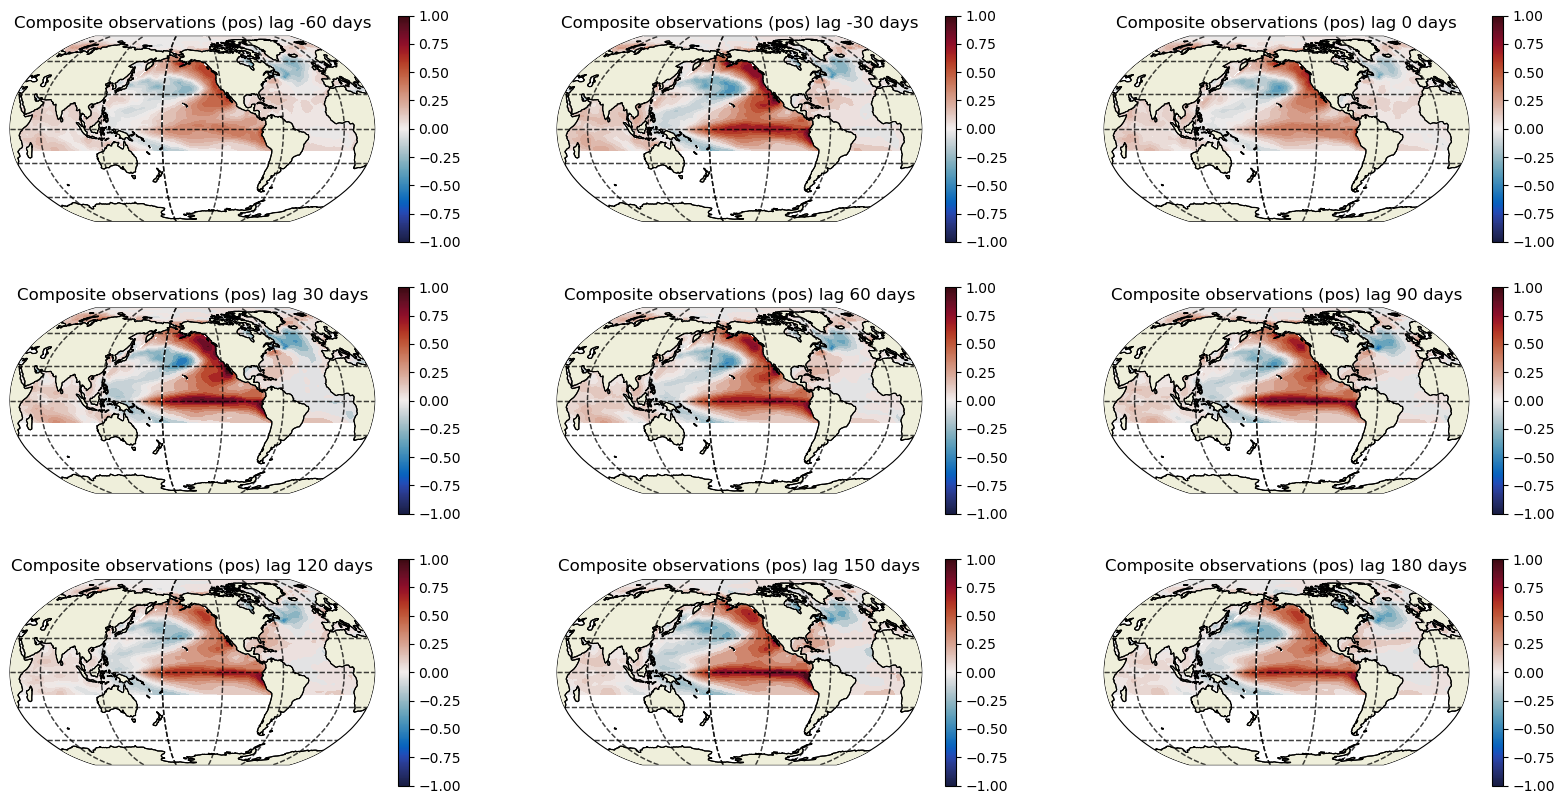

In [16]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_pos'], axis=(0,1))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (pos) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (positive)")
plt.show()

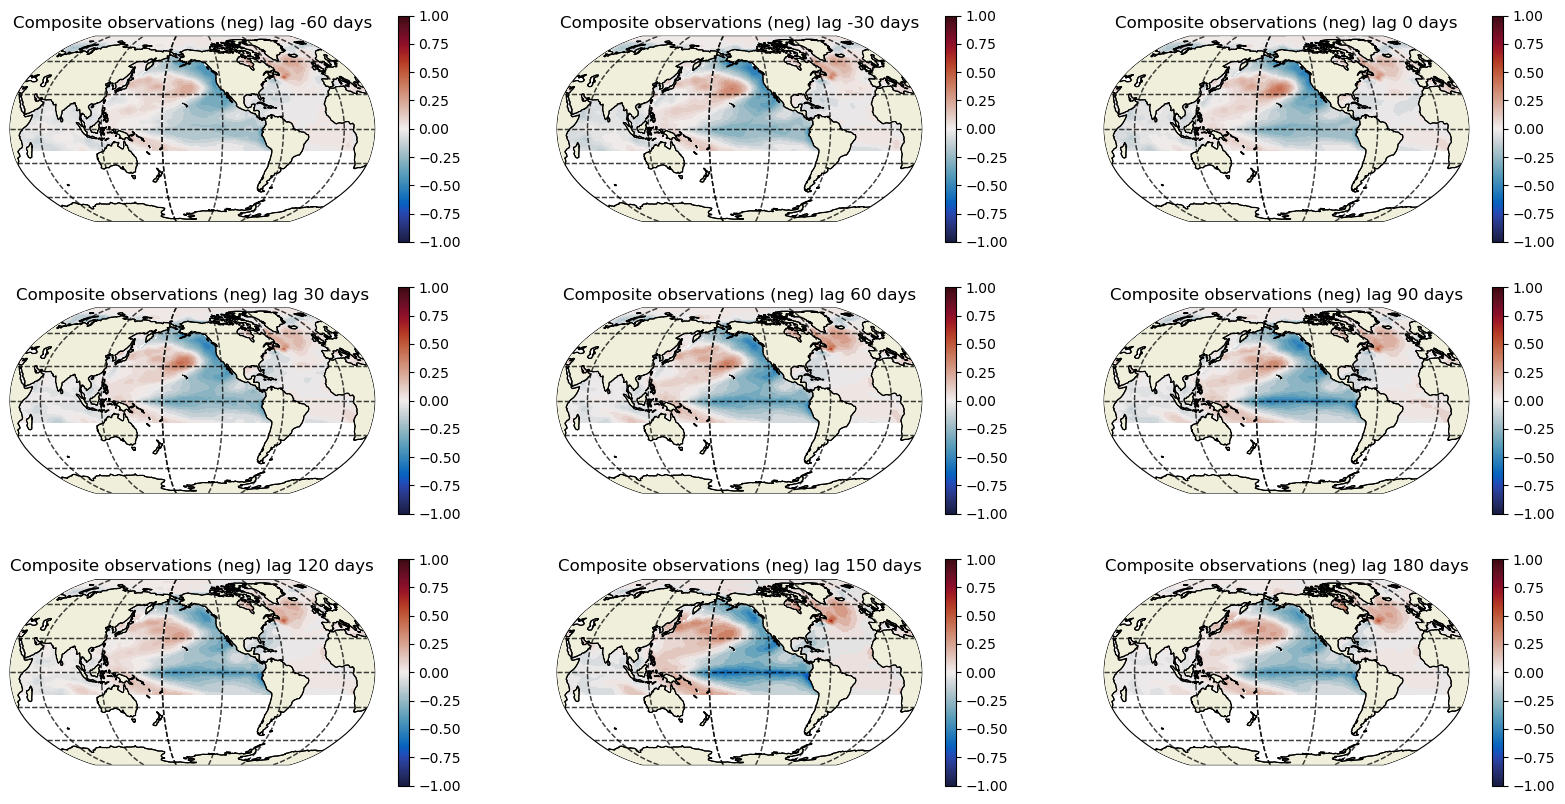

In [17]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_neg'], axis=(0,1))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (neg) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (negative)")
plt.show()

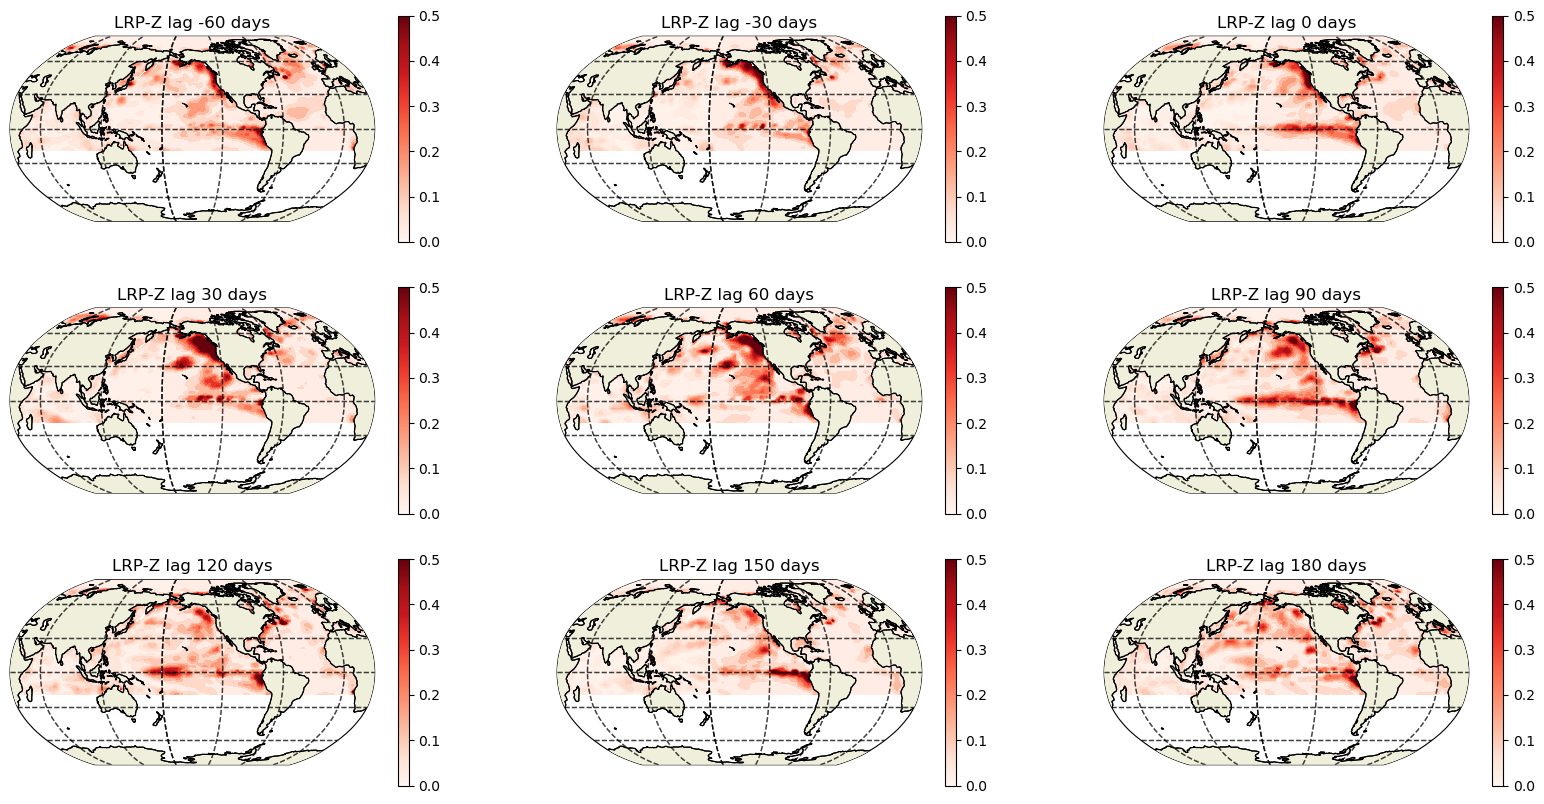

In [18]:
subplot_idx = 1

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['name']+'_pos'].copy()
        field[np.where(field < 0)] = 0.0
        field = np.nanmean(field, axis=(0,1))
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='Reds', cmin = 0, cmax = 0.5,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

        P[1].set_title(f"{method['title']} lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    # plt.title(f"{method['title']} for pos QoI' w/o neg relevances")
    plt.show()

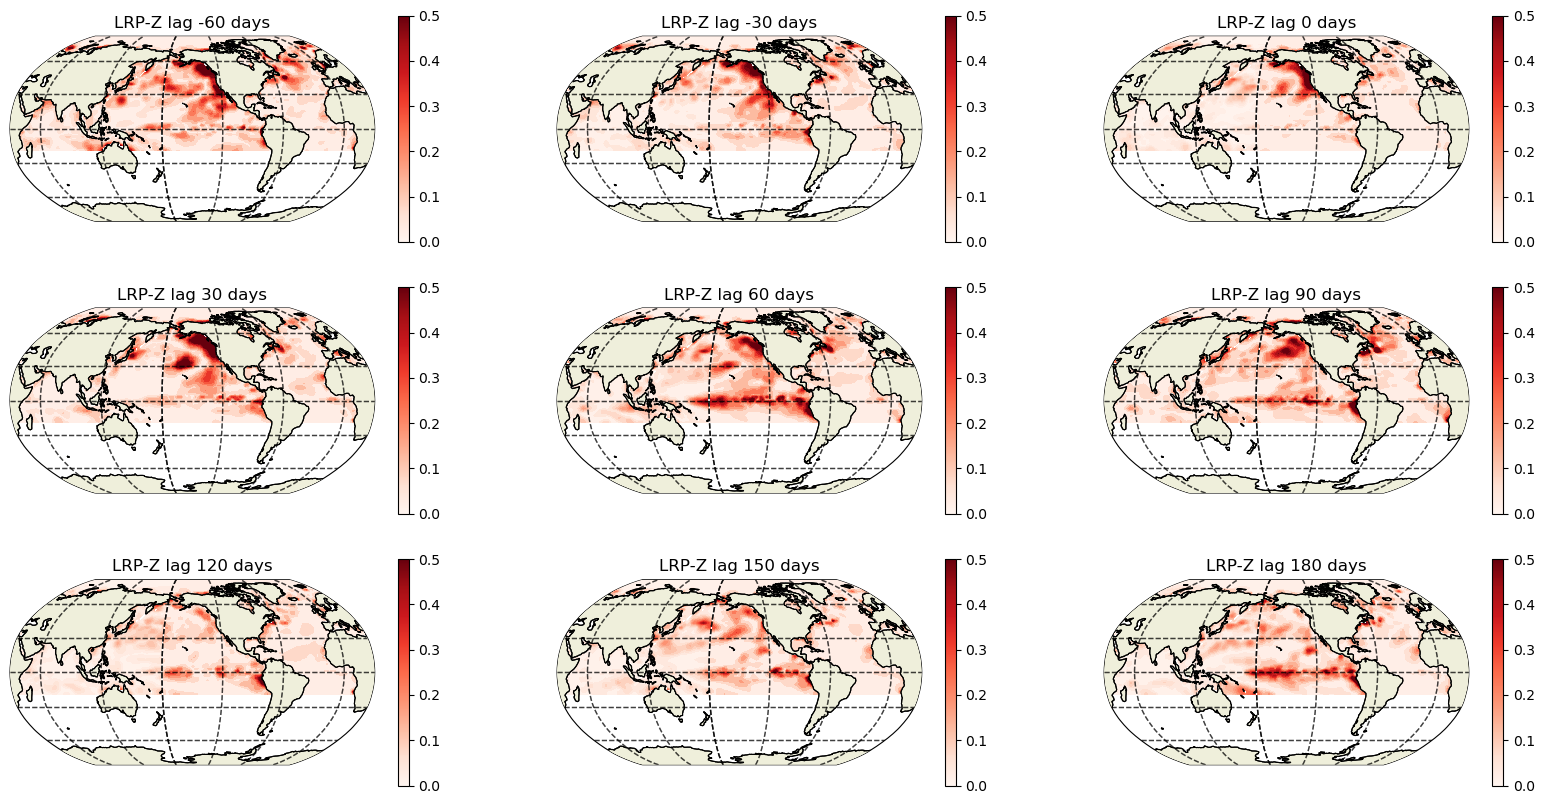

In [19]:
subplot_idx = 1

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['name']+'_neg'].copy()
        field[np.where(field < 0)] = 0.0
        field = np.nanmean(field, axis=(0,1))
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='Reds', cmin = 0, cmax = 0.5,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])
        
        P[1].set_title(f"{method['title']} lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    # plt.title(f"{method['title']} for neg QoI' w/o neg relevances")
    plt.show()

## Classification - Train-test data split

In [20]:
def quickSetup(X, y_oneHot, y,
               test_split_frac,
               numVars, 
               lrp_methods, 
               lagSteps,
               decay_func = None,
               **NNkwargs):
    
    result = {}

    idx = int(X.shape[0]*(1-test_split_frac))
    X_train = X[:idx]
    y_oneHot_train = y_oneHot[:idx]
    y_train = y[:idx]
    oneHotCost_train = oneHotCost[:idx]
    X_test = X[idx:]
    y_oneHot_test = y_oneHot[idx:]
    y_test = y[idx:]
    oneHotCost_test = oneHotCost[idx:]

    while True:

        keras.backend.clear_session()
        sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
        NNkwargs['optimizer'] = sgd
        
        if lagSteps > 0:
            K = TrainFullyConnectedNN(X_train[:-lagSteps], y_oneHot_train[lagSteps:], **NNkwargs)
        elif lagSteps == 0:
            K = TrainFullyConnectedNN(X_train, y_oneHot_train, **NNkwargs)
        else:
            K = TrainFullyConnectedNN(X_train[-lagSteps:], y_oneHot_train[:lagSteps], **NNkwargs)
            
        best_model = K.quickTrain(decay_func)
        result['cost_predict_NN'] = best_model.predict(X)
        result['cost_predict_NN_train'] = best_model.predict(X_train)
        result['cost_predict_NN_test'] = best_model.predict(X_test)
    
        result['score_train'] = best_model.evaluate(X_train, y_oneHot_train, verbose=0)
        result['score_test'] = best_model.evaluate(X_test, y_oneHot_test, verbose=0)
    
        normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
        kwargs = {'y_ref': 0.00}
    
        # LRP for training data
        pred_NN = result['cost_predict_NN_train'].copy()
        pred_NN[:,0] = pred_NN[:,0] > 0.5
        pred_NN[:,1] = pred_NN[:,1] > 0.5
    
        idx_NN_pos = []
        idx_NN_neg = []
    
        if lagSteps >= 0:
            for i in range(len(oneHotCost_train[lagSteps:,0])):
                if oneHotCost_train[lagSteps+i,0] == 1 and pred_NN[i,0] == 1:
                    idx_NN_pos.append(i)
                if oneHotCost_train[lagSteps+i,1] == 1 and pred_NN[i,1] == 1:
                    idx_NN_neg.append(i)
        else:
            for i in range(len(oneHotCost_train[:lagSteps,0])):
                if oneHotCost_train[i,0] == 1 and pred_NN[i-lagSteps,0] == 1:
                    idx_NN_pos.append(i-lagSteps)
                if oneHotCost_train[i,1] == 1 and pred_NN[i-lagSteps,1] == 1:
                    idx_NN_neg.append(i-lagSteps)        

        if len(idx_NN_pos) != 0 and len(idx_NN_neg) != 0:
            break

    print(np.sum(oneHotCost_train[:,0]), np.sum(oneHotCost_train[:,1]))
    print(len(idx_NN_pos), len(idx_NN_neg))

    # Create model without trailing softmax
    model_wo_softmax = innvestigate.model_wo_softmax(best_model)
                   
    rel = np.zeros((numVars, len(idx_NN_pos), 13, 90, 90))
    rel[:,:,:,:,:] = np.nan

    for numvar in range(numVars):
        rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = X_train[idx_NN_pos].T
    result['samples_correct_pos_train'] = rel

    rel = np.zeros((numVars, len(idx_NN_neg), 13, 90, 90))
    rel[:,:,:,:,:] = np.nan
        
    for numvar in range(numVars):
        rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = X_train[idx_NN_neg].T
    result['samples_correct_neg_train'] = rel
                   
    for method in lrp_methods:

        title = method['title']
        
        print(f'Analyze using {title} for train data')
        
        Xplain = XAIR(model_wo_softmax, method, 'classic', X_train[idx_NN_pos], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, a.shape[0], 13, 90, 90))
        rel[:,:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a[:,numvar*perVar:(numvar+1)*perVar].T
        result[method['name']+'_pos_train'] = rel

        Xplain = XAIR(model_wo_softmax, method, 'classic', X_train[idx_NN_neg], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, a.shape[0], 13, 90, 90))
        rel[:,:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a[:,numvar*perVar:(numvar+1)*perVar].T
        result[method['name']+'_neg_train'] = rel

    # LRP for test data
    pred_NN = result['cost_predict_NN_test'].copy()
    pred_NN[:,0] = pred_NN[:,0] > 0.5
    pred_NN[:,1] = pred_NN[:,1] > 0.5

    idx_NN_pos = []
    idx_NN_neg = []

    if lagSteps >= 0:
        for i in range(len(oneHotCost_test[lagSteps:,0])):
            if oneHotCost_test[lagSteps+i,0] == 1 and pred_NN[i,0] == 1:
                idx_NN_pos.append(i)
            if oneHotCost_test[lagSteps+i,1] == 1 and pred_NN[i,1] == 1:
                idx_NN_neg.append(i)
    else:
        for i in range(len(oneHotCost_test[:lagSteps,0])):
            if oneHotCost_test[i,0] == 1 and pred_NN[i-lagSteps,0] == 1:
                idx_NN_pos.append(i-lagSteps)
            if oneHotCost_test[i,1] == 1 and pred_NN[i-lagSteps,1] == 1:
                idx_NN_neg.append(i-lagSteps)    

    print(np.sum(oneHotCost_test[:,0]), np.sum(oneHotCost_test[:,1]))
    print(len(idx_NN_pos), len(idx_NN_neg))

    rel = np.zeros((numVars, len(idx_NN_pos), 13, 90, 90))
    rel[:,:,:,:,:] = np.nan

    for numvar in range(numVars):
        rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = X_test[idx_NN_pos].T
    result['samples_correct_pos_test'] = rel

    rel = np.zeros((numVars, len(idx_NN_neg), 13, 90, 90))
    rel[:,:,:,:,:] = np.nan
        
    for numvar in range(numVars):
        rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = X_test[idx_NN_neg].T
    result['samples_correct_neg_test'] = rel
                   
    for method in lrp_methods:

        title = method['title']
        
        print(f'Analyze using {title} for test data')
        
        Xplain = XAIR(model_wo_softmax, method, 'classic', X_test[idx_NN_pos], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, a.shape[0], 13, 90, 90))
        rel[:,:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a[:,numvar*perVar:(numvar+1)*perVar].T
        result[method['name']+'_pos_test'] = rel

        Xplain = XAIR(model_wo_softmax, method, 'classic', X_test[idx_NN_neg], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, a.shape[0], 13, 90, 90))
        rel[:,:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a[:,numvar*perVar:(numvar+1)*perVar].T
        result[method['name']+'_neg_test'] = rel
        
    return result

In [21]:
Layers = [{'size': X.shape[1], 'activation': None     , 'use_bias': None},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': False, 'l2_w_reg': 10  , 'l2_b_reg': 10},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': False, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01},
          {'size': 2         , 'activation': 'softmax', 'use_bias': False, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01}]
Losses = [{'kind': 'categorical_crossentropy', 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 25
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    return lrate


methods = [dict(name='lrp.z',                        optParams = {}                    , title = 'LRP-Z')]

In [22]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    
    NNkwargs = {'losses': Losses, 'metrics': [metrics.categorical_accuracy],
                'batch_size': 128, 'epochs': 100, 'validation_split': 0.2,
                'filename': 'model', 'dirname': os.path.abspath(''),
                'random_nn_seed': 42}
    
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(X, oneHotCost, y, test_split_frac = 1.0/3.0,
                                                        numVars = 1, lrp_methods = methods,
                                                        lagSteps = lagStepsList[i],
                                                        decay_func = step_decay,
                                                        layers = Layers, **NNkwargs)

Lag: -60 days, for Theta


2023-12-16 21:42:51.313655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:42:51.315712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:42:51.317704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.32603, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 1.32603 to 1.14889, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 1.14889

Epoch 4: val_loss improved from 1.14889 to 0.81725, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 5: val_loss did not improve from 0.81725

Epoch 6: val_loss did not improve from 0.81725

Epoch 7: val_loss did not improve from 0.81725

Epoch 8: val_loss did not improve from 0.81725

Epoch 9: val_loss did not improve from 0.81725

Epoch 10: val_loss improved from 0.81725 to 0.81122, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 11: val_loss did not improve from 0.81122

Epoch 12: val_loss did not improve from 0.81122

Epoch 13: val_loss improved from 0.81122 to 0.80628, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 14: val_loss did not improve from 

2023-12-16 21:43:42.147272: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:43:42.149364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:43:42.151379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.39297, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 1.39297

Epoch 3: val_loss improved from 1.39297 to 1.21409, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 1.21409

Epoch 5: val_loss did not improve from 1.21409

Epoch 6: val_loss improved from 1.21409 to 1.12965, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 7: val_loss did not improve from 1.12965

Epoch 8: val_loss improved from 1.12965 to 0.85568, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 9: val_loss did not improve from 0.85568

Epoch 10: val_loss did not improve from 0.85568

Epoch 11: val_loss did not improve from 0.85568

Epoch 12: val_loss did not improve from 0.85568

Epoch 13: val_loss improved from 0.85568 to 0.81155, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 14: val_loss did not improve from 

2023-12-16 21:44:24.619372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:44:24.621425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:44:24.623433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.47567, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 1.47567 to 0.83725, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 0.83725

Epoch 4: val_loss did not improve from 0.83725

Epoch 5: val_loss did not improve from 0.83725

Epoch 6: val_loss improved from 0.83725 to 0.83665, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 7: val_loss did not improve from 0.83665

Epoch 8: val_loss did not improve from 0.83665

Epoch 9: val_loss improved from 0.83665 to 0.82807, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 10: val_loss did not improve from 0.82807

Epoch 11: val_loss did not improve from 0.82807

Epoch 12: val_loss did not improve from 0.82807

Epoch 13: val_loss did not improve from 0.82807

Epoch 14: val_loss did not improve from 0.82807

Epoch 15: val_loss did not improve from 0.82807

Epoch 16:

2023-12-16 21:45:11.827146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:45:11.829220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:45:11.831242: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.78562, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 1.78562 to 1.10715, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 1.10715

Epoch 4: val_loss did not improve from 1.10715

Epoch 5: val_loss improved from 1.10715 to 0.98454, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 6: val_loss did not improve from 0.98454

Epoch 7: val_loss did not improve from 0.98454

Epoch 8: val_loss improved from 0.98454 to 0.97022, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 9: val_loss did not improve from 0.97022

Epoch 10: val_loss did not improve from 0.97022

Epoch 11: val_loss did not improve from 0.97022

Epoch 12: val_loss did not improve from 0.97022

Epoch 13: val_loss did not improve from 0.97022

Epoch 14: val_loss did not improve from 0.97022

Epoch 15: val_loss did not improve from 0.97022

Epoch 16:

2023-12-16 21:45:57.401503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:45:57.403563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:45:57.405555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.95720, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 0.95720

Epoch 3: val_loss improved from 0.95720 to 0.89427, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 0.89427

Epoch 5: val_loss improved from 0.89427 to 0.88522, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 6: val_loss did not improve from 0.88522

Epoch 7: val_loss did not improve from 0.88522

Epoch 8: val_loss did not improve from 0.88522

Epoch 9: val_loss did not improve from 0.88522

Epoch 10: val_loss did not improve from 0.88522

Epoch 11: val_loss did not improve from 0.88522

Epoch 12: val_loss did not improve from 0.88522

Epoch 13: val_loss did not improve from 0.88522

Epoch 14: val_loss did not improve from 0.88522

Epoch 15: val_loss did not improve from 0.88522

Epoch 16: val_loss did not improve from 0.88522

Epoch 17: val_loss improved

2023-12-16 21:46:45.250814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:46:45.252875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:46:45.257039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.96000, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 0.96000

Epoch 3: val_loss did not improve from 0.96000

Epoch 4: val_loss did not improve from 0.96000

Epoch 5: val_loss did not improve from 0.96000

Epoch 6: val_loss did not improve from 0.96000

Epoch 7: val_loss improved from 0.96000 to 0.84441, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 8: val_loss did not improve from 0.84441

Epoch 9: val_loss did not improve from 0.84441

Epoch 10: val_loss did not improve from 0.84441

Epoch 11: val_loss did not improve from 0.84441

Epoch 12: val_loss did not improve from 0.84441

Epoch 13: val_loss did not improve from 0.84441

Epoch 14: val_loss did not improve from 0.84441

Epoch 15: val_loss did not improve from 0.84441

Epoch 16: val_loss improved from 0.84441 to 0.78422, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 17: val_loss did not 

2023-12-16 21:47:30.678847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:47:30.680894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:47:30.682891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.03641, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 1.03641 to 0.85123, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 0.85123

Epoch 4: val_loss did not improve from 0.85123

Epoch 5: val_loss did not improve from 0.85123

Epoch 6: val_loss did not improve from 0.85123

Epoch 7: val_loss did not improve from 0.85123

Epoch 8: val_loss did not improve from 0.85123

Epoch 9: val_loss did not improve from 0.85123

Epoch 10: val_loss did not improve from 0.85123

Epoch 11: val_loss improved from 0.85123 to 0.84056, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 12: val_loss did not improve from 0.84056

Epoch 13: val_loss improved from 0.84056 to 0.79591, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 14: val_loss did not improve from 0.79591

Epoch 15: val_loss did not improve from 0.79591

Epoch 16:

2023-12-16 21:48:12.592694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:48:12.594751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:48:12.596737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.97300, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 0.97300

Epoch 3: val_loss improved from 0.97300 to 0.88668, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 0.88668

Epoch 5: val_loss did not improve from 0.88668

Epoch 6: val_loss improved from 0.88668 to 0.88625, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 7: val_loss did not improve from 0.88625

Epoch 8: val_loss improved from 0.88625 to 0.84506, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 9: val_loss did not improve from 0.84506

Epoch 10: val_loss did not improve from 0.84506

Epoch 11: val_loss did not improve from 0.84506

Epoch 12: val_loss did not improve from 0.84506

Epoch 13: val_loss did not improve from 0.84506

Epoch 14: val_loss did not improve from 0.84506

Epoch 15: val_loss did not improve from 0.84506

Epoch 16:

2023-12-16 21:48:57.375838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-12-16 21:48:57.377903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-12-16 21:48:57.379885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.04065, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 1.04065

Epoch 3: val_loss improved from 1.04065 to 1.03251, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 1.03251

Epoch 5: val_loss did not improve from 1.03251

Epoch 6: val_loss improved from 1.03251 to 0.84031, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 7: val_loss did not improve from 0.84031

Epoch 8: val_loss did not improve from 0.84031

Epoch 9: val_loss did not improve from 0.84031

Epoch 10: val_loss did not improve from 0.84031

Epoch 11: val_loss did not improve from 0.84031

Epoch 12: val_loss did not improve from 0.84031

Epoch 13: val_loss did not improve from 0.84031

Epoch 14: val_loss did not improve from 0.84031

Epoch 15: val_loss did not improve from 0.84031

Epoch 16: val_loss did not improve from 0.84031

Epoch 17: val_loss did not 

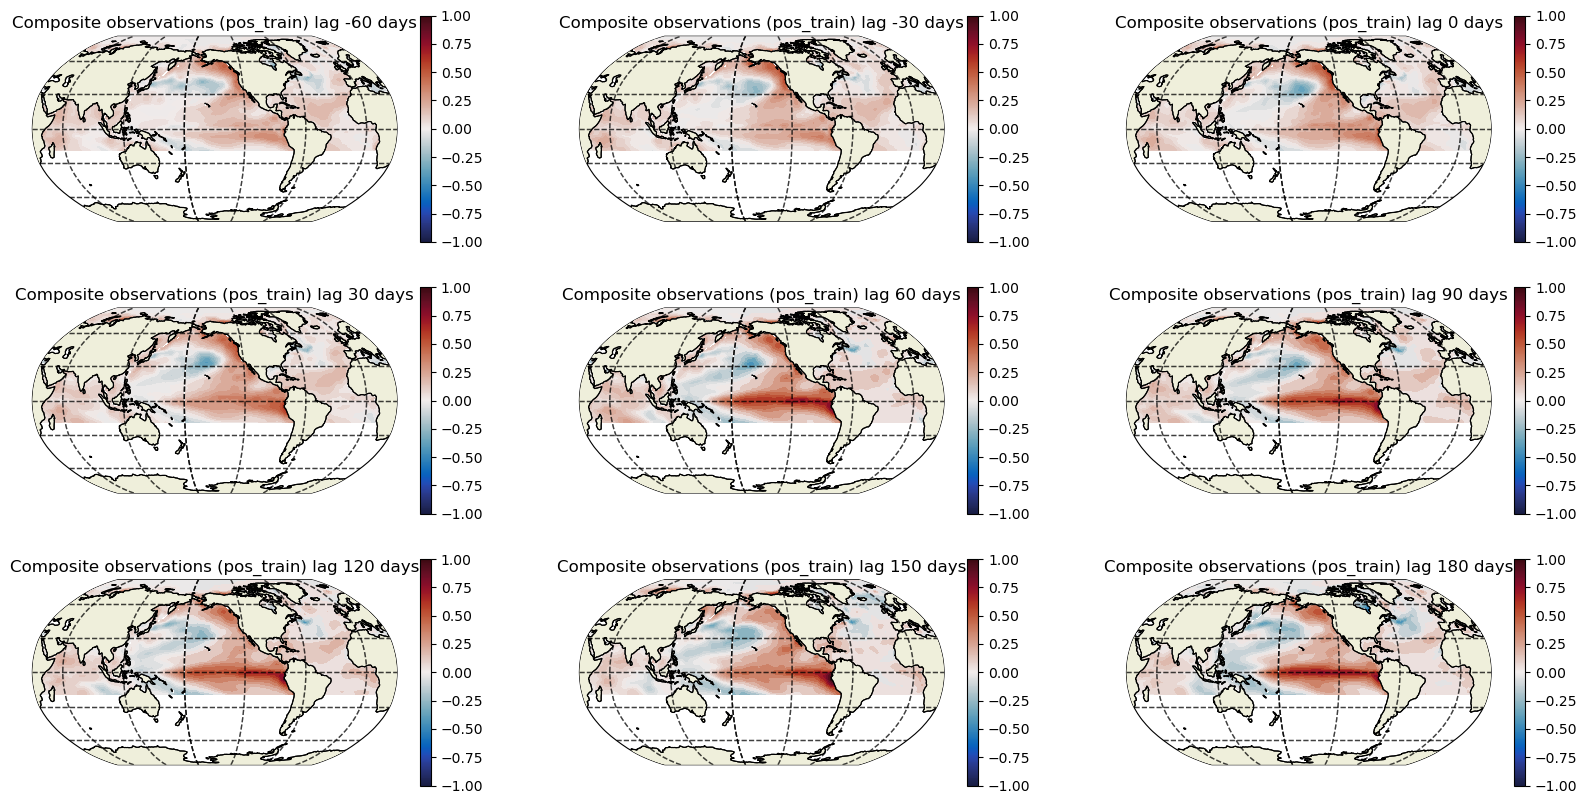

In [23]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_pos_train'], axis=(0,1))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (pos_train) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (positive_train)")
plt.show()

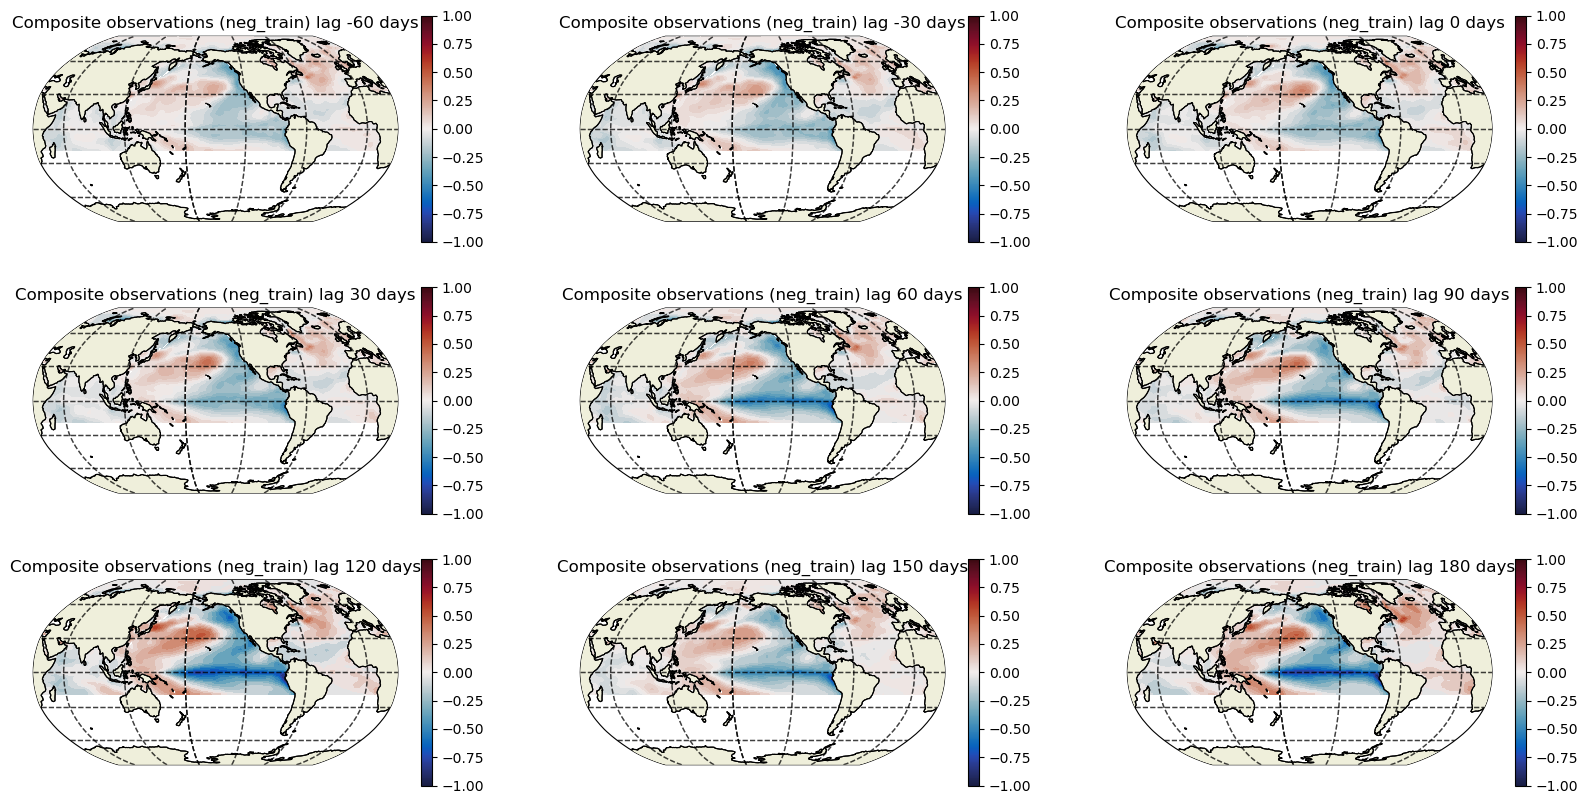

In [24]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_neg_train'], axis=(0,1))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (neg_train) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (negative_train)")
plt.show()

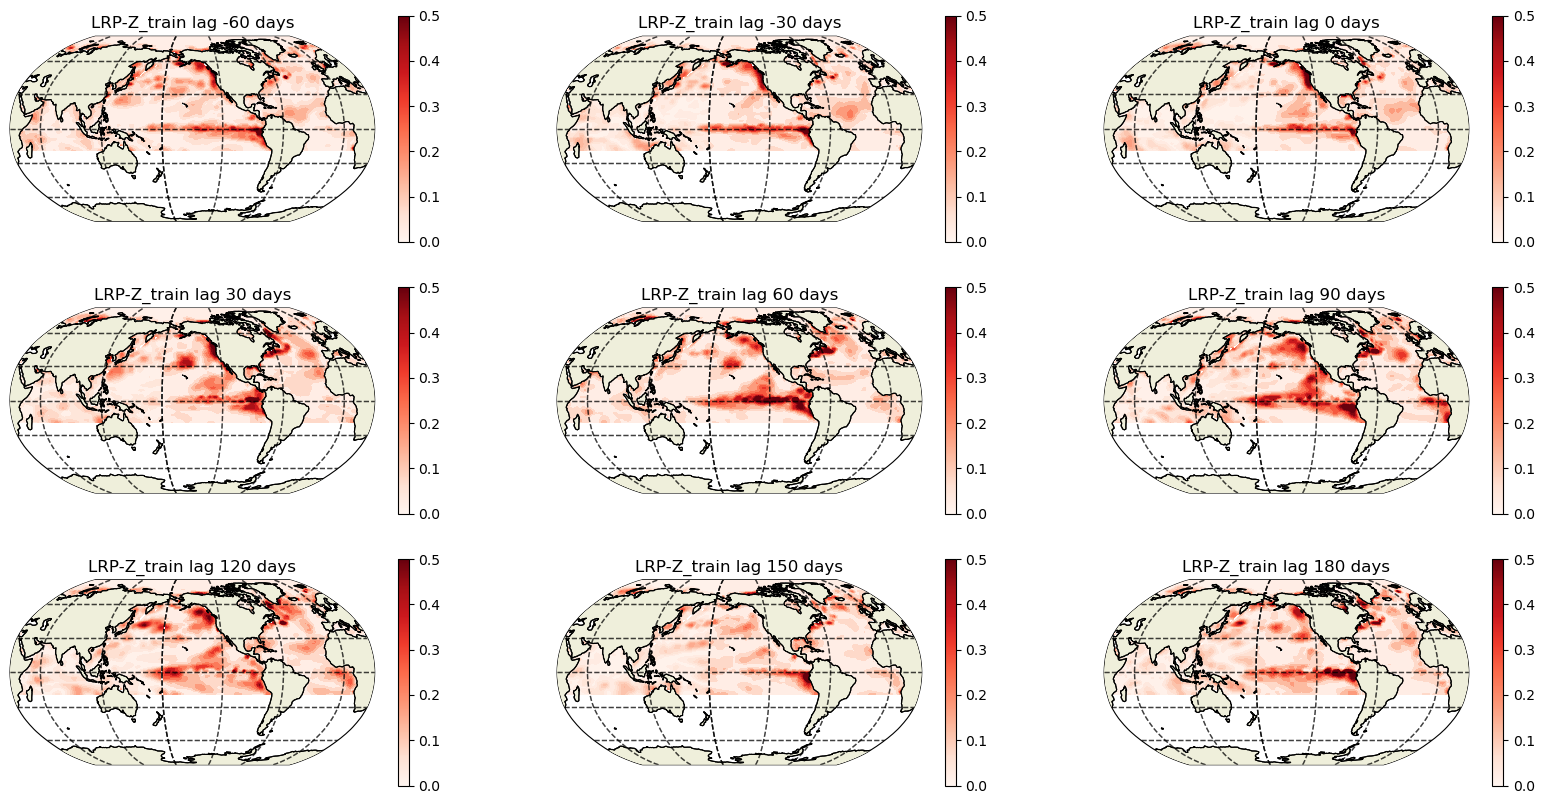

In [25]:
subplot_idx = 1

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['name']+'_pos_train'].copy()
        field[np.where(field < 0)] = 0.0
        field = np.nanmean(field, axis=(0,1))
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='Reds', cmin = 0, cmax = 0.5,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

        P[1].set_title(f"{method['title']}_train lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    # plt.title(f"{method['title']}_train for pos QoI' w/o neg relevances")
    plt.show()

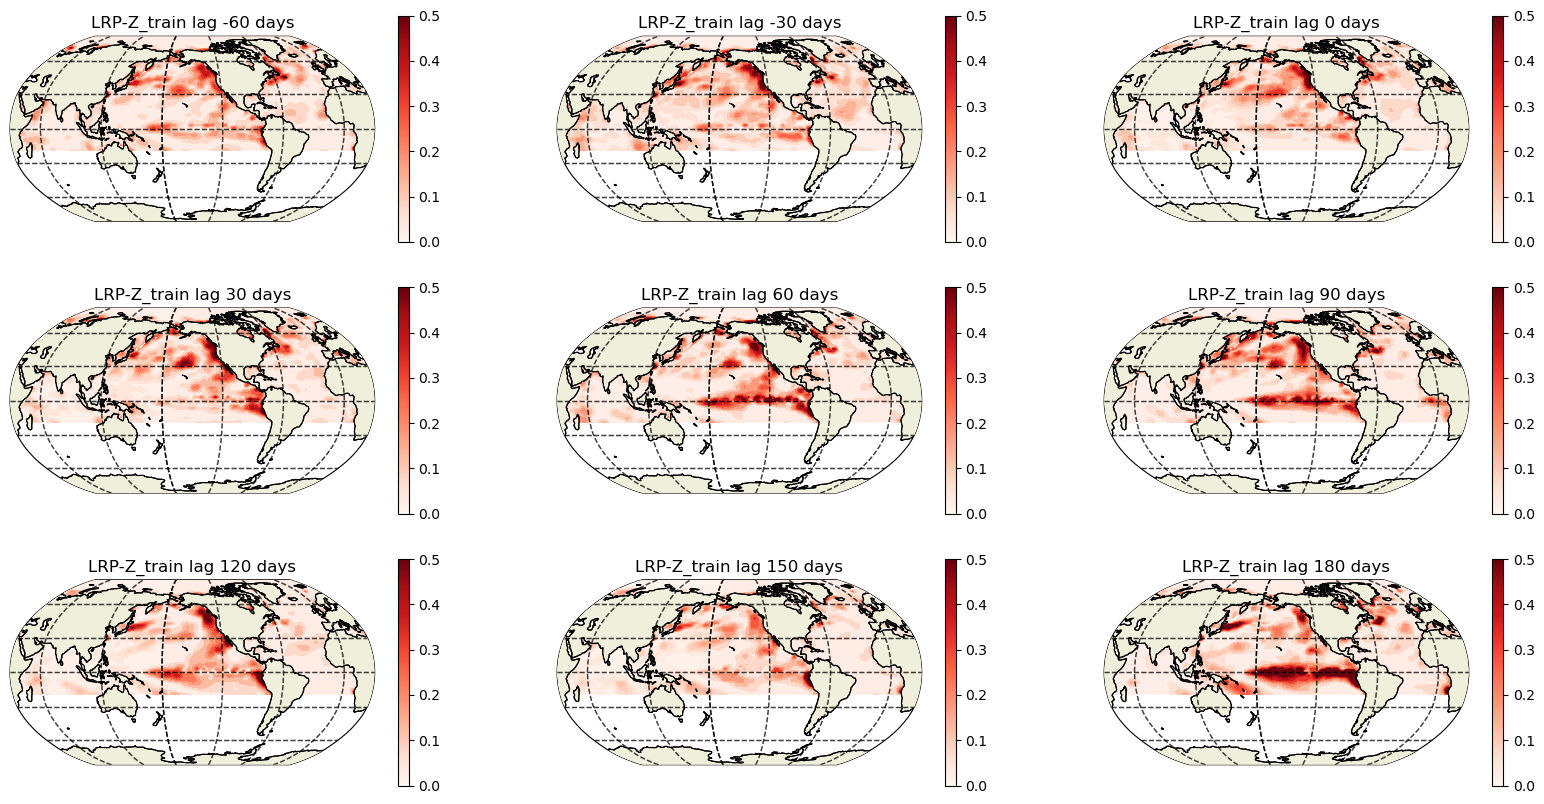

In [26]:
subplot_idx = 1

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['name']+'_neg_train'].copy()
        field[np.where(field < 0)] = 0.0
        field = np.nanmean(field, axis=(0,1))
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='Reds', cmin = 0, cmax = 0.5,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])
        
        P[1].set_title(f"{method['title']}_train lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    # plt.title(f"{method['title']}_train for neg QoI' w/o neg relevances")
    plt.show()

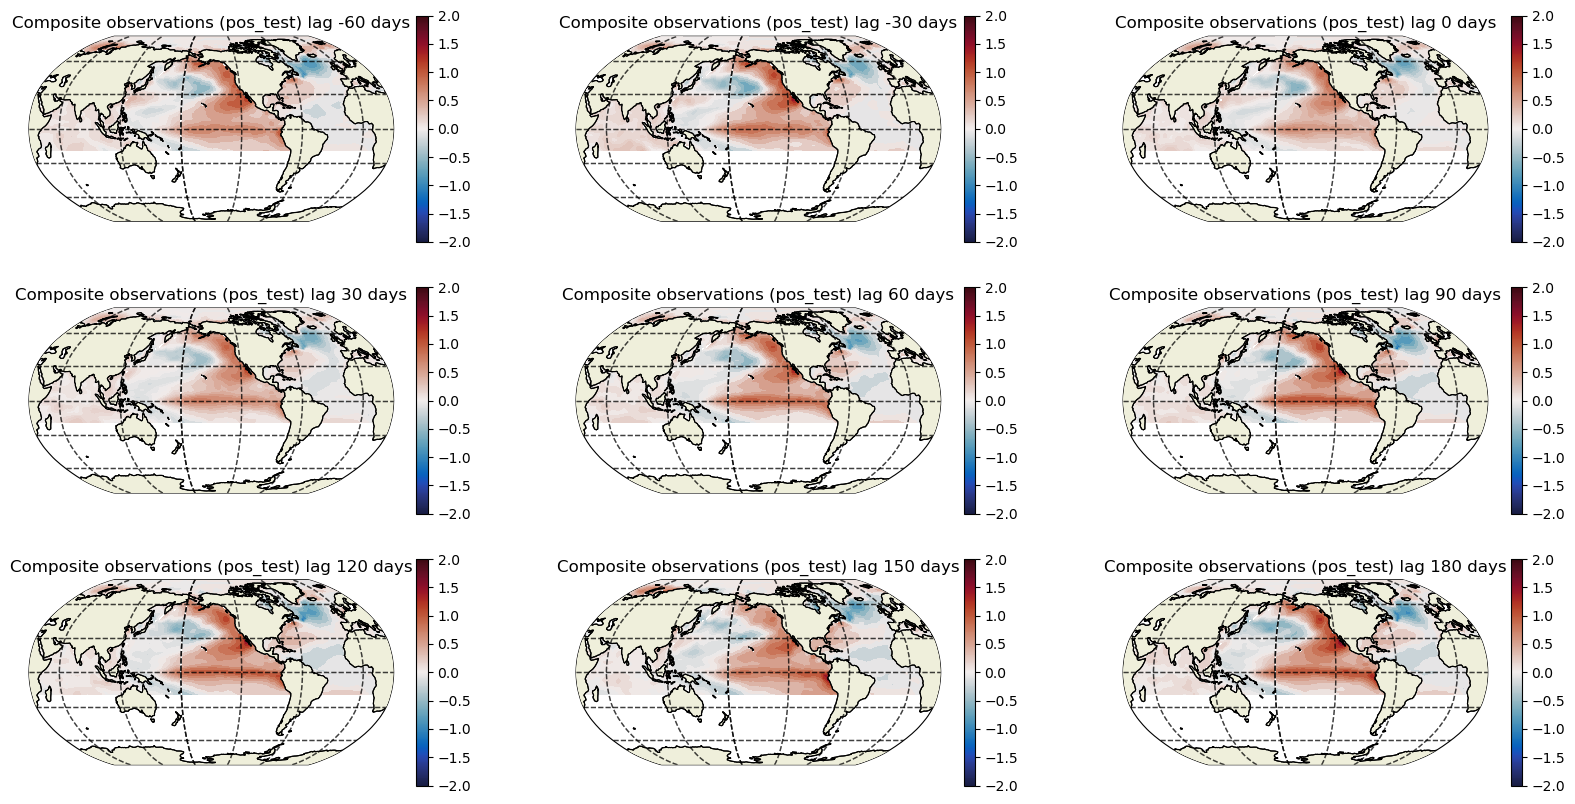

In [27]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_pos_test'], axis=(0,1))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -2, cmax = 2,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (pos_test) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (positive_test)")
plt.show()

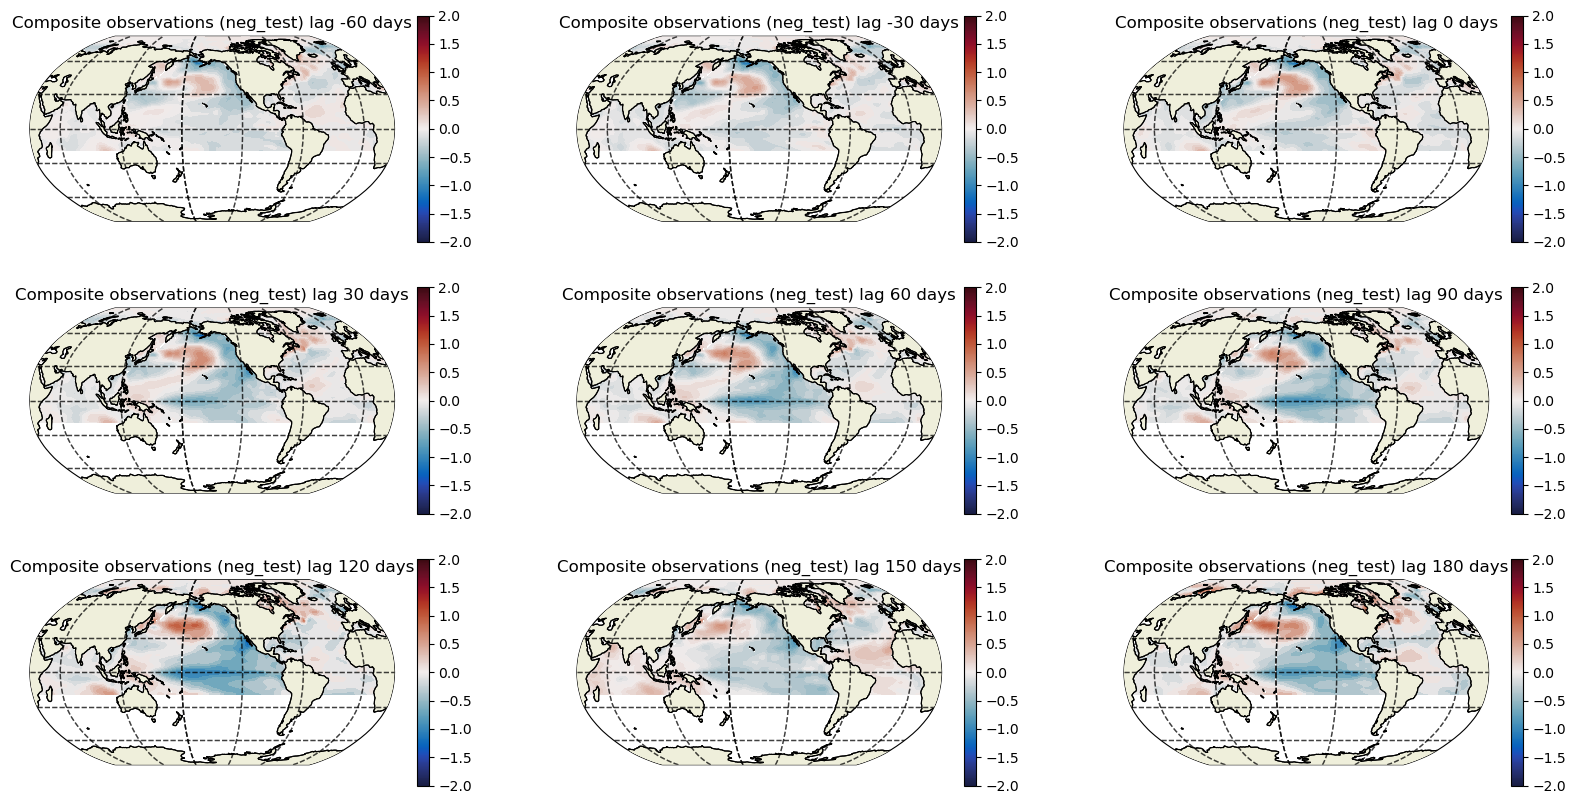

In [28]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_neg_test'], axis=(0,1))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -2, cmax = 2,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (neg_test) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (negative_test)")
plt.show()

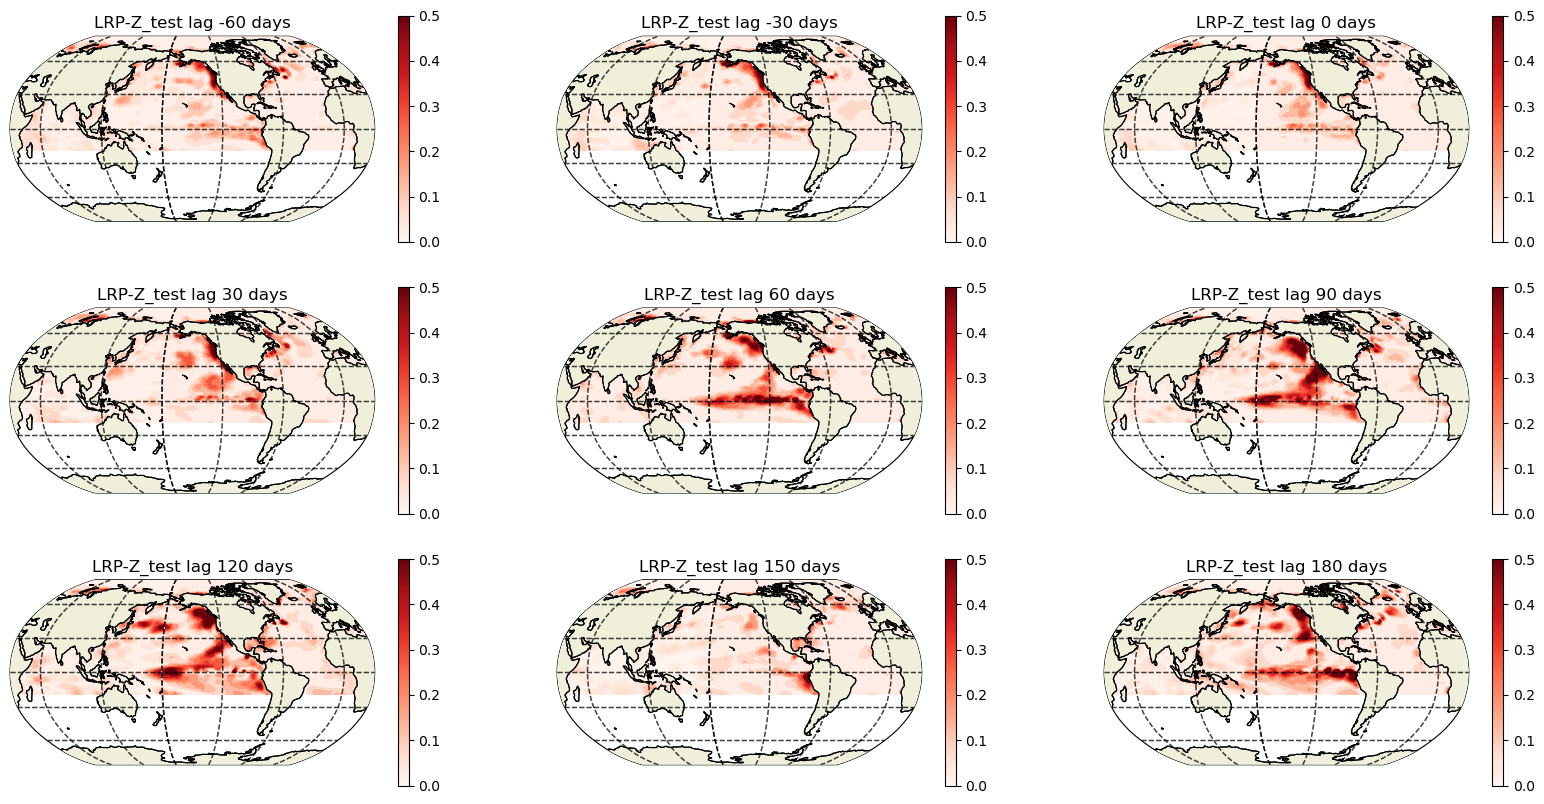

In [29]:
subplot_idx = 1

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['name']+'_pos_test'].copy()
        field[np.where(field < 0)] = 0.0
        field = np.nanmean(field, axis=(0,1))
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='Reds', cmin = 0, cmax = 0.5,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

        P[1].set_title(f"{method['title']}_test lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    # plt.title(f"{method['title']}_test for pos QoI' w/o neg relevances")
    plt.show()

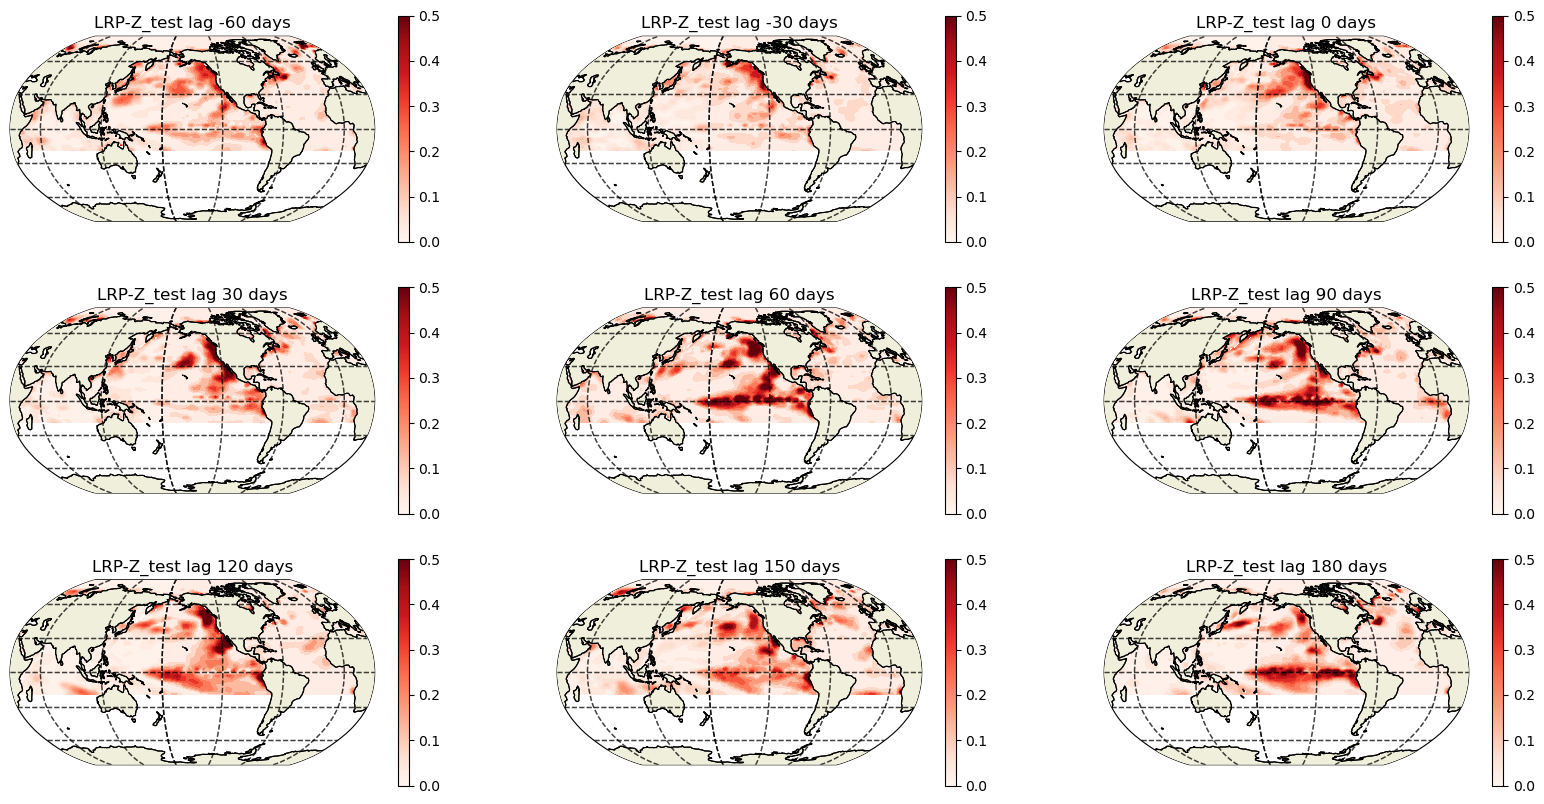

In [31]:
subplot_idx = 1

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['name']+'_neg_test'].copy()
        field[np.where(field < 0)] = 0.0
        field = np.nanmean(field, axis=(0,1))
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='Reds', cmin = 0, cmax = 0.5,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])
        
        P[1].set_title(f"{method['title']}_test lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    # plt.title(f"{method['title']}_test for neg QoI' w/o neg relevances")
    plt.show()

## Regression

In [ ]:
def quickSetup(X, y, 
               numVars, 
               lrp_methods, 
               lagSteps,
               decay_func = None,
               **NNkwargs):
    
    result = {}
    
    if lagSteps > 0:
        K = TrainFullyConnectedNN(X[:-lagSteps], y[lagSteps:], **NNkwargs)
    elif lagSteps == 0:
        K = TrainFullyConnectedNN(X, y, **NNkwargs)
    else:
        K = TrainFullyConnectedNN(X[-lagSteps:], y[:lagSteps], **NNkwargs)
        
    best_model = K.quickTrain(decay_func)
    result['cost_predict_NN'] = best_model.predict(X)    
    
    normalizeDict = {'bool_': True, 'kind': 'Sum'}
    kwargs = {'y_ref': 0.00}
                   
    for method in lrp_methods:

        title = method['title']
        
        print(f'Analyze using {title}')

        Xplain = XAIR(best_model, method, 'classic', X, 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, a.shape[0], 13, 90, 90))
        rel[:,:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a[:,numvar*perVar:(numvar+1)*perVar].T
        result[method['name']] = rel
        
    return result

In [ ]:
Layers = [{'size': X.shape[1], 'activation': None     , 'use_bias': None},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': False, 'l2_w_reg': 10  , 'l2_b_reg': 10},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': False, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01},
          {'size': 1         , 'activation': 'linear',  'use_bias': False, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01}]
Losses = [{'kind': 'mean_squared_error', 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 25.0
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    return lrate

methods = [dict(name='lrp.z',                        optParams = {}                    , title = 'LRP-Z')]

In [ ]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')

    adam = keras.optimizers.Adam()
    # sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    
    NNkwargs = {'losses': Losses, 'optimizer': adam, 'metrics': ['mse'],
                'batch_size': 128, 'epochs': 100, 'validation_split': 0.2,
                'filename': 'model', 'dirname': os.path.abspath('')}
    
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(X, y,
                                                        numVars = 1, lrp_methods = methods,
                                                        lagSteps = lagStepsList[i],
                                                        decay_func = step_decay,
                                                        layers = Layers, **NNkwargs)

In [ ]:
subplot_idx = 1

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['name']].copy()
        field = np.nanmean(field, axis=(0,1))
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='RdBu_r', cmin = -0.3, cmax = 0.3,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

        P[1].set_title(f"{method['title']} lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    # plt.title(f"{method['title']} for QoI'")
    plt.show()

In [ ]:
subplot_idx = 1

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['name']].copy()
        field = np.nanmean(np.abs(field), axis=(0,1))
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='Reds', cmin = 0, cmax = 0.5,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

        P[1].set_title(f"{method['title']} lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    # plt.title(f"{method['title']} for QoI' with abs. relevances")
    plt.show()